# Comparing epochs

Outdated notebook and data.

In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.io as spio
from scipy import stats
import pandas as pd
import pickle

import ccf_analysis_utils
import functions as func

In [2]:
def get_single_area_inds(area, df, ccf_labels):
    subregion_labels = func.get_all_subregion_annotations_from_name(df, area)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, {area: subregion_labels})
    return inds[area]

In [3]:
areas = ['Medulla','Midbrain','ALM', 'Striatum', 'Thalamus',]

In [4]:
df = pd.read_excel('mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx',engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

r2_new = pickle.load(open('r2_data_dict_clipped.pkl', 'rb'))
epochs = ['sample','delay','response']
r2_methods = ['old', 'old_clipped', 'new']

method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}

for iepoch, epoch in enumerate(epochs):
    for ir2, r2method in enumerate(r2_methods):
        r2method_string = method_to_string[r2method]
        r2 = r2_new['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()
        if r2method == 'old_clipped':
            r2[r2<0] = 0

        ccf_labels = r2_new['5_0']['ccf_labels'].copy()
        ccf_coords = r2_new['5_0']['ccf_coords'].copy()
        fr = r2_new['5_0']['%s_fr'%epoch].copy()

        area_values = []
        area_sems = []
        n_neurons = []
        for j, area in enumerate(areas):
            inds = get_single_area_inds(area, df, ccf_labels)
            n_neurons.append(len(inds))
            mean = r2[inds].mean()
            std = r2[inds].std()
            sem = std/np.sqrt(inds.shape[0])
            area_values.append(mean)
            area_sems.append(sem)

        plt.figure(figsize=(8,6))
        plt.bar(np.arange(0,len(areas)), area_values, yerr = area_sems, alpha = 0.8, capsize = 3)
        plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
        plt.ylabel('mean R2, %s'%r2method)
        plt.title('All neurons, %s'%epoch)
        for j in range(len(areas)):
            plt.text(j-0.3,1.1*np.nanmax(area_values), 'n=%d'%n_neurons[j], fontsize=10, color='black')

        plt.ylim(0,0.28)
        plt.savefig('figs/mean_r2_by_area_all_animals_%s_%s.png'%(epoch, r2method))
        plt.close()

In [5]:
r2_newest = pickle.load(open('r2_data_dict_timeshifts.pkl', 'rb'))
ccf_labels_v2 = r2_newest['5_0']['ccf_labels'].copy()
is_alm = r2_newest['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]
areas = ['Medulla','Midbrain','ALM', 'Striatum', 'Thalamus',]

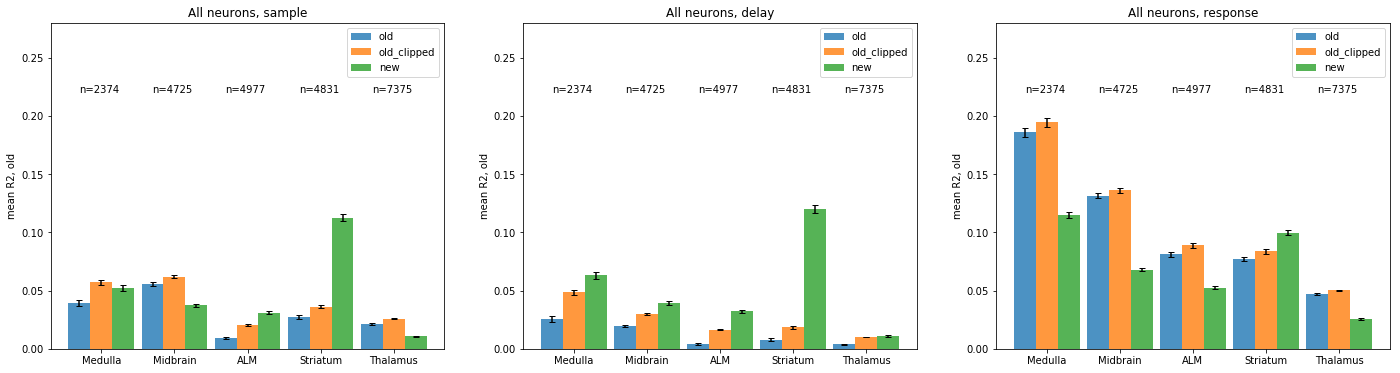

In [6]:
plt.subplots(1,3,figsize=(24,6))
for iepoch, epoch in enumerate(epochs):
    plt.subplot(1,3,iepoch+1)
    for ir2, r2method in enumerate(r2_methods):
        r2method_string = method_to_string[r2method]
        r2 = r2_newest['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()
        if r2method == 'old_clipped':
            r2[r2<0] = 0

        ccf_labels = r2_newest['5_0']['ccf_labels'].copy()

        area_values = []
        area_sems = []
        n_neurons = []
        for j, area in enumerate(areas):
            if area == 'ALM':
                inds = alm_inds
            else:
                inds = get_single_area_inds(area, df, ccf_labels)
            n_neurons.append(len(inds))
            mean = r2[inds].mean()
            std = r2[inds].std()
            sem = std/np.sqrt(inds.shape[0])
            area_values.append(mean)
            area_sems.append(sem)

        
        plt.bar(np.arange(0,len(areas)) + (- 0.3 + ir2*0.3), 
                area_values, yerr = area_sems, alpha = 0.8, 
                capsize = 3, width=0.3, label = r2method)
        
        
        if ir2 == 0: 
            plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
            plt.ylabel('mean R2, %s'%r2method)
            plt.title('All neurons, %s'%epoch)
            for j in range(len(areas)):
                plt.text(j-0.3,0.22, 'n=%d'%n_neurons[j], fontsize=10, color='black')

        plt.ylim(0,0.28)
    plt.legend()
plt.savefig('figs/epochs/mean_r2_by_area_all_animals.png')
plt.show()
plt.close()

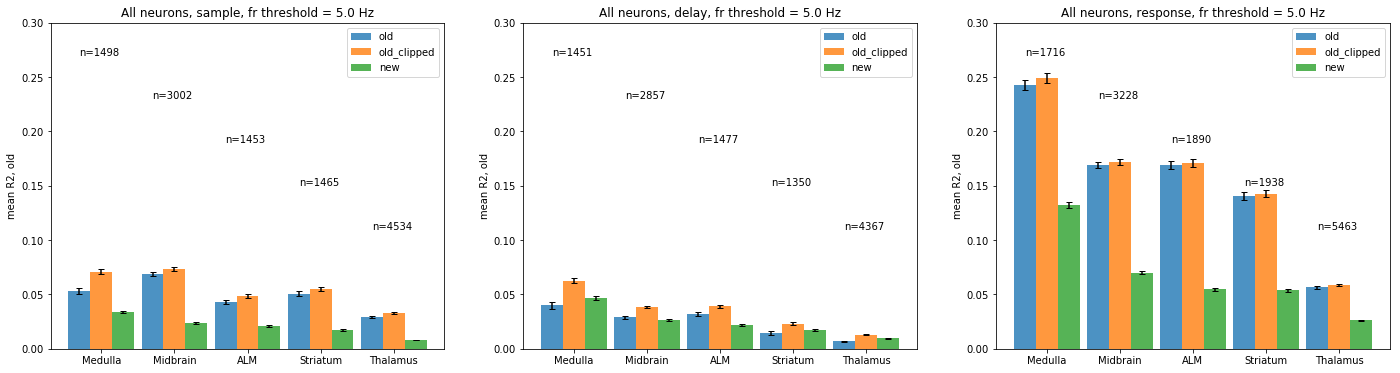

In [7]:
fr_cutoff = 5

plt.subplots(1,3,figsize=(24,6))
for iepoch, epoch in enumerate(epochs):
    plt.subplot(1,3,iepoch+1)
    for ir2, r2method in enumerate(r2_methods):
        r2method_string = method_to_string[r2method]
        r2 = r2_newest['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()
        fr = r2_newest['5_0']['%s_fr'%epoch].copy()

        if r2method == 'old_clipped':
            r2[r2<0] = 0

        fr_inds = np.where(fr>fr_cutoff)[0]

        ccf_labels = r2_newest['5_0']['ccf_labels'].copy()

        area_values = []
        area_sems = []
        n_neurons = []
        for j, area in enumerate(areas):
            if area == 'ALM':
                inds = alm_inds
            else:
                inds = get_single_area_inds(area, df, ccf_labels)
            inds = np.intersect1d(inds, fr_inds)
            n_neurons.append(len(inds))
            mean = r2[inds].mean()
            std = r2[inds].std()
            sem = std/np.sqrt(inds.shape[0])
            area_values.append(mean)
            area_sems.append(sem)

        
        plt.bar(np.arange(0,len(areas)) + (- 0.3 + ir2*0.3), 
                area_values, yerr = area_sems, alpha = 0.8, 
                capsize = 3, width=0.3, label = r2method)
        
        
        if ir2 == 0: 
            plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
            plt.ylabel('mean R2, %s'%r2method)
            plt.title('All neurons, %s, fr threshold = %.1f Hz'%(epoch, fr_cutoff))
            for j in range(len(areas)):
                plt.text(j-0.3,0.27-0.04*j, 'n=%d'%n_neurons[j], fontsize=10, color='black')

        plt.ylim(0,0.30)
    plt.legend()
plt.savefig('figs/epochs/mean_r2_by_area_all_animals_fr_cutoff.png')
plt.show()
plt.close()

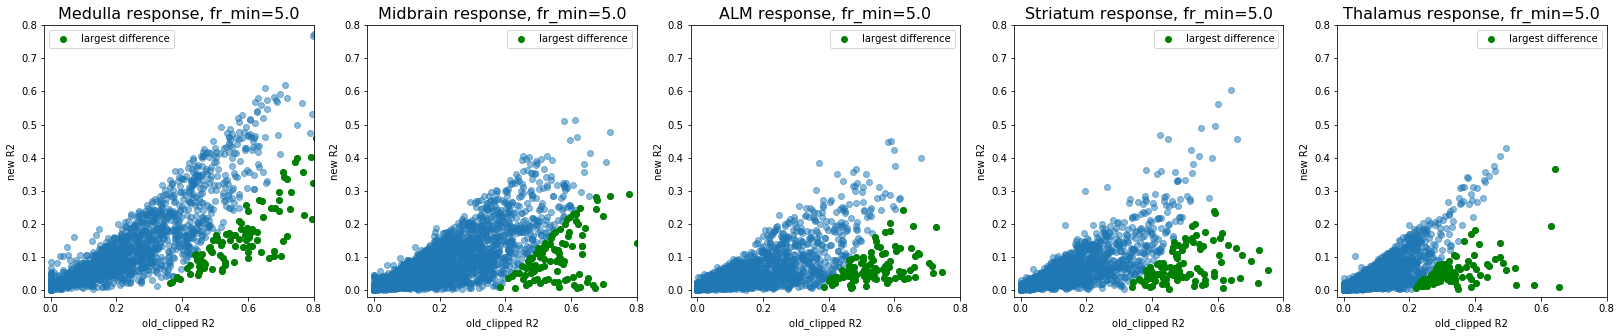

In [8]:
plt.subplots(1,5,figsize=(28,5))
fr_cutoff = 5
area_large_diff_inds = {}



for j,area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds
    else:
        inds = get_single_area_inds(area, df, ccf_labels_v2)

    fr = r2_newest['5_0']['response_fr'].copy()
    fr_inds = np.where(fr>fr_cutoff)[0]
    inds = np.intersect1d(inds, fr_inds)
    
    old_r2 = r2_newest['5_0']['response_r2_old'][inds]
    new_r2 = r2_newest['5_0']['response_r2'][inds]
    old_clipped_r2 = old_r2.copy()
    old_clipped_r2[old_clipped_r2<0] = 0

    plt.subplot(1,5,j + 1)
    plt.plot(old_clipped_r2,new_r2, 'o', alpha = 0.5)

    large_diff_inds = np.argsort(np.abs(old_clipped_r2 - new_r2))[::-1][:100]

    plt.plot(old_clipped_r2[large_diff_inds], new_r2[large_diff_inds], 'go', label = 'largest difference')

    area_large_diff_inds[area] = np.sort(inds)[large_diff_inds]

    plt.ylabel('new R2')
    plt.xlabel('old_clipped R2')
    plt.title('%s response, fr_min=%.1f'%(area,fr_cutoff), fontsize=16)
    plt.xlim(-0.02,0.8)
    plt.ylim(-0.02,0.8)
    plt.legend()

plt.savefig('figs/epochs/scatter_r2_comparisons_response_fr_cutoff.png')
plt.show()
plt.close()

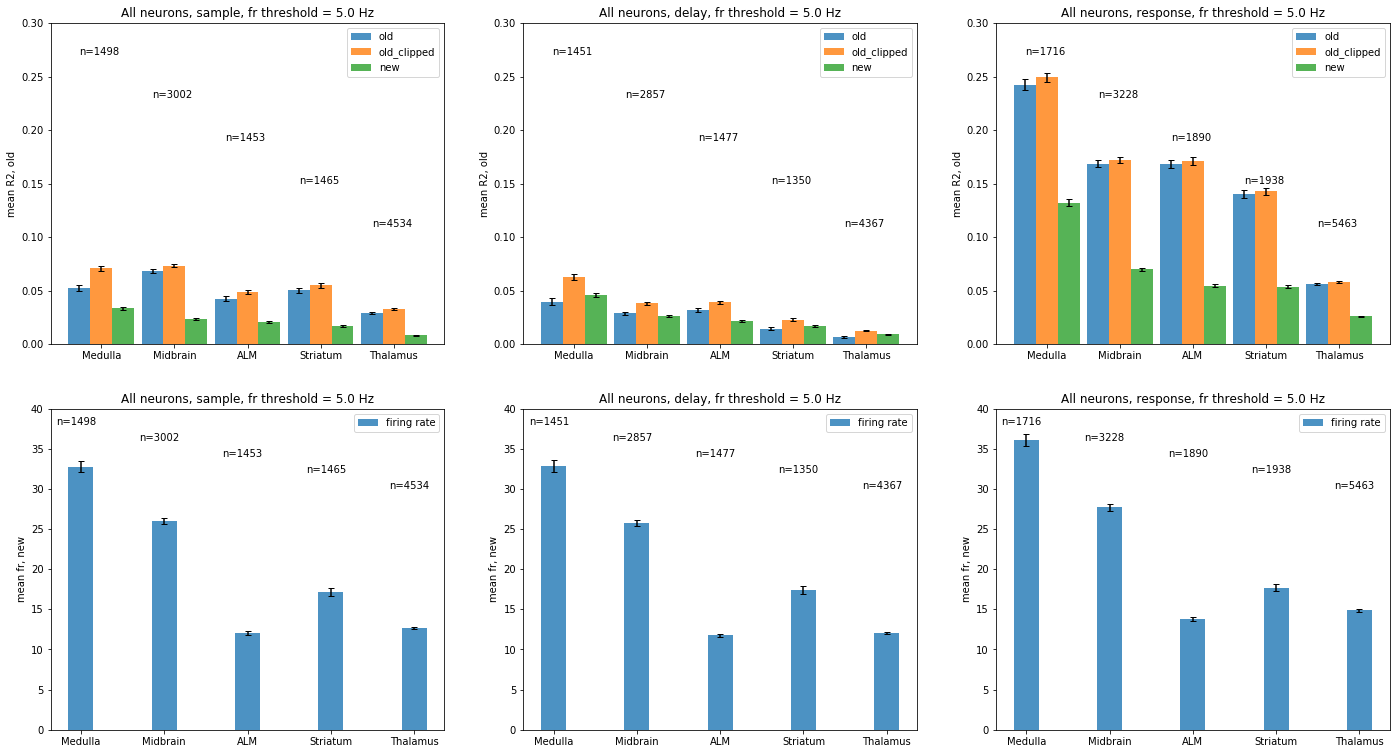

In [12]:
fr_cutoff = 5

plt.subplots(2,3,figsize=(24,13))
for iepoch, epoch in enumerate(epochs):
    plt.subplot(2,3,iepoch+1)
    for ir2, r2method in enumerate(r2_methods):
        r2method_string = method_to_string[r2method]
        r2 = r2_newest['5_0']['%s_r2%s'%(epoch, r2method_string)].copy()
        fr = r2_newest['5_0']['%s_fr'%epoch].copy()

        if r2method == 'old_clipped':
            r2[r2<0] = 0

        fr_inds = np.where(fr>fr_cutoff)[0]

        ccf_labels = r2_newest['5_0']['ccf_labels'].copy()

        area_values = []
        area_sems = []
        n_neurons = []
        for j, area in enumerate(areas):
            if area == 'ALM':
                inds = alm_inds
            else:
                inds = get_single_area_inds(area, df, ccf_labels)
            inds = np.intersect1d(inds, fr_inds)
            n_neurons.append(len(inds))
            mean = r2[inds].mean()
            std = r2[inds].std()
            sem = std/np.sqrt(inds.shape[0])
            area_values.append(mean)
            area_sems.append(sem)

        
        plt.bar(np.arange(0,len(areas)) + (- 0.3 + ir2*0.3), 
                area_values, yerr = area_sems, alpha = 0.8, 
                capsize = 3, width=0.3, label = r2method)
        
        
        if ir2 == 0: 
            plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
            plt.ylabel('mean R2, %s'%r2method)
            plt.title('All neurons, %s, fr threshold = %.1f Hz'%(epoch, fr_cutoff))
            for j in range(len(areas)):
                plt.text(j-0.3,0.27-0.04*j, 'n=%d'%n_neurons[j], fontsize=10, color='black')

        plt.ylim(0,0.30)
    plt.legend()

    plt.subplot(2,3,3 + iepoch+1)
    fr = r2_newest['5_0']['%s_fr'%epoch].copy()

    fr_inds = np.where(fr>fr_cutoff)[0]

    ccf_labels = r2_newest['5_0']['ccf_labels'].copy()

    area_values = []
    area_sems = []
    n_neurons = []
    for j, area in enumerate(areas):
        if area == 'ALM':
            inds = alm_inds
        else:
            inds = get_single_area_inds(area, df, ccf_labels)
        inds = np.intersect1d(inds, fr_inds)
        n_neurons.append(len(inds))
        mean = fr[inds].mean()
        std = fr[inds].std()
        sem = std/np.sqrt(inds.shape[0])
        area_values.append(mean)
        area_sems.append(sem)

    
    plt.bar(np.arange(0,len(areas)), 
            area_values, yerr = area_sems, alpha = 0.8, 
            capsize = 3, width=0.3, label = 'firing rate')
        
        
    plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
    plt.ylabel('mean fr, %s'%r2method)
    plt.title('All neurons, %s, fr threshold = %.1f Hz'%(epoch, fr_cutoff))
    for j in range(len(areas)):
        plt.text(j-0.3,38-2*j, 'n=%d'%n_neurons[j], fontsize=10, color='black')


    plt.ylim(0,40)
    plt.legend()
plt.savefig('figs/epochs/mean_r2_fr_by_area_all_animals_fr_cutoff.png')
plt.show()
plt.close()

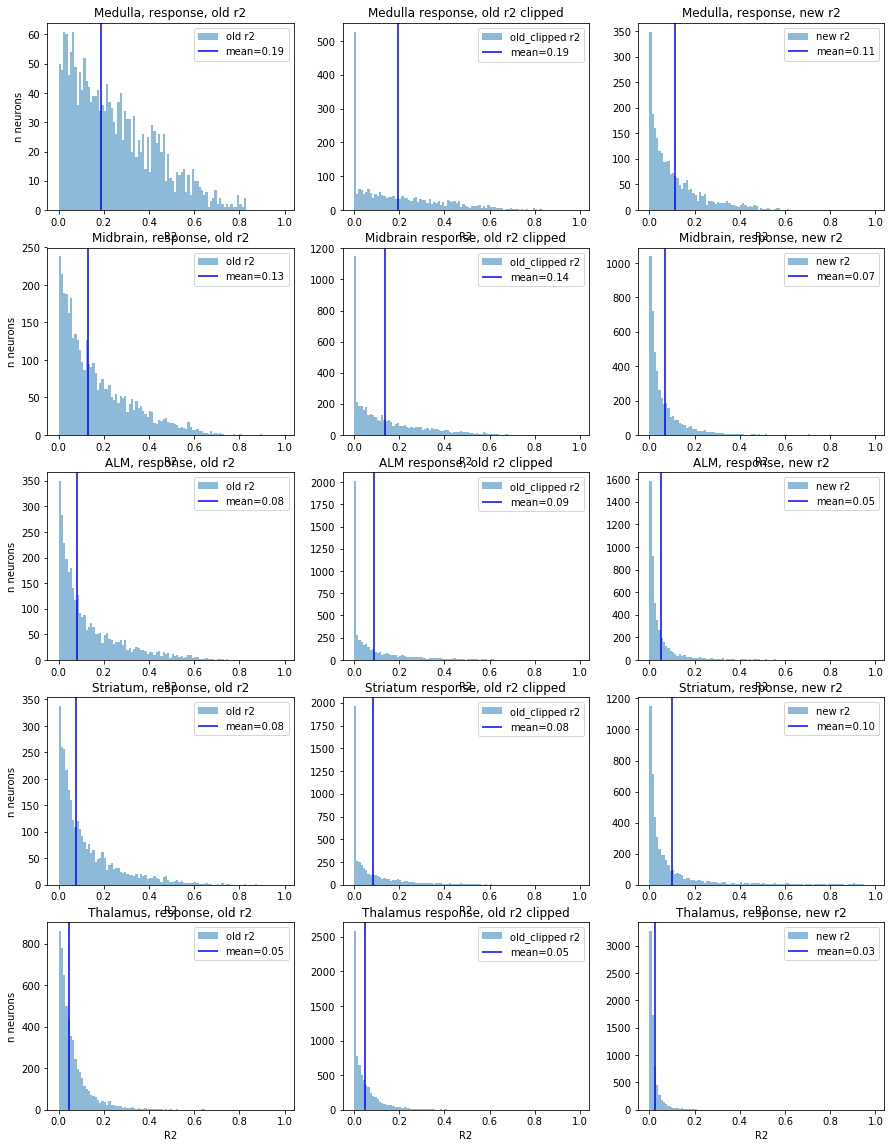

In [49]:
plt.subplots(5,3,figsize=(15,20))

for j,area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds
    else:
        inds = get_single_area_inds(area, df, ccf_labels_v2)

    old_r2 = r2_newest['5_0']['response_r2_old'][inds]
    new_r2 = r2_newest['5_0']['response_r2'][inds]
    old_clipped_r2 = old_r2.copy()
    old_clipped_r2[old_clipped_r2<0] = 0


    plt.subplot(5,3,3*j + 1)
    plt.hist(old_r2, bins = np.arange(0,1.,0.01), alpha = 0.5, label = 'old r2')
    mean = old_r2.mean()
    a,b = plt.ylim()
    plt.vlines(mean, a, b, color = 'blue', label = 'mean=%.2f'%mean)
    plt.ylim(a,b)
    plt.xlabel('R2')
    plt.ylabel('n neurons')
    plt.title('%s, response, old r2'%area)
    plt.legend()

    plt.subplot(5,3,3*j + 2)
    plt.hist(old_clipped_r2, bins = np.arange(0,1.,0.01), alpha = 0.5, label = 'old_clipped r2')
    mean = old_clipped_r2.mean()
    a,b = plt.ylim()
    plt.vlines(mean, a, b, color = 'blue', label = 'mean=%.2f'%mean)
    plt.ylim(a,b)
    plt.xlabel('R2')
    plt.title('%s response, old r2 clipped'%area)
    plt.legend()

    plt.subplot(5,3,3*j + 3)
    plt.hist(new_r2, bins = np.arange(0,1.,0.01), alpha = 0.5, label = 'new r2')
    mean = new_r2.mean()
    a,b = plt.ylim()
    plt.vlines(mean, a, b, color = 'blue', label = 'mean=%.2f'%mean)
    plt.ylim(a,b)
    plt.xlabel('R2')
    plt.title('%s, response, new r2'%area)
    plt.legend()
        
plt.savefig('figs/epochs/hist_r2_comparisons_animals_response.png')
plt.show()
plt.close()

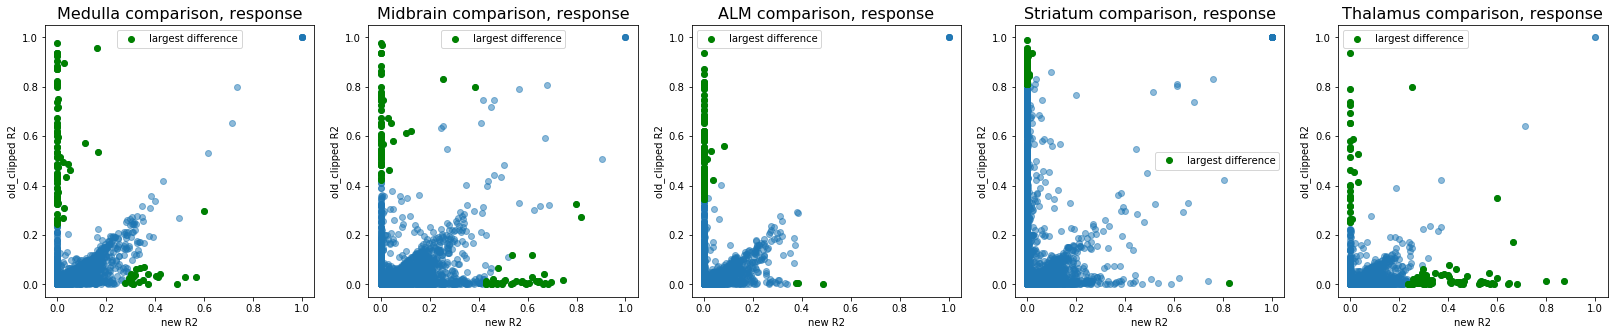

In [52]:
plt.subplots(1,5,figsize=(28,5))

area_large_diff_inds = {}

for j,area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds
    else:
        inds = get_single_area_inds(area, df, ccf_labels_v2)

    old_r2 = r2_newest['5_0']['sample_r2_old'][inds]
    new_r2 = r2_newest['5_0']['sample_r2'][inds]
    old_clipped_r2 = old_r2.copy()
    old_clipped_r2[old_clipped_r2<0] = 0

    plt.subplot(1,5,j + 1)
    plt.plot(old_clipped_r2,new_r2, 'o', alpha = 0.5)

    large_diff_inds = np.argsort(np.abs(old_clipped_r2 - new_r2))[::-1][:100]

    plt.plot(old_clipped_r2[large_diff_inds], new_r2[large_diff_inds], 'go', label = 'largest difference')

    area_large_diff_inds[area] = np.sort(inds)[large_diff_inds]

    plt.xlabel('new R2')
    plt.ylabel('old_clipped R2')
    plt.title('%s comparison, response'%area, fontsize=16)
    plt.legend()

plt.savefig('figs/epochs/scatter_r2_comparisons_response.png')
plt.show()
plt.close()

In [76]:
large_diff_raw_r2 = pickle.load(open('large_diff_for_r2_method.pkl', 'rb'))

In [82]:
large_diff_raw_r2['Striatum']['SC065_20210511_11'].shape

(662, 2, 5)

In [89]:
_temp_dict = pickle.load(open('r2_scores_SC035_20200108_34_5_5_12.pkl', 'rb'))
_temp_dict.keys()

UnpicklingError: pickle data was truncated

In [83]:
striatum_r2s = []
for k in large_diff_raw_r2['Striatum'].keys():
    this_r2_array = large_diff_raw_r2['Striatum'][k]
    striatum_r2s.append(this_r2_array)

striatum_r2s = np.concatenate(striatum_r2s,axis = 1)

In [90]:
relu = lambda x: np.maximum(x,0)

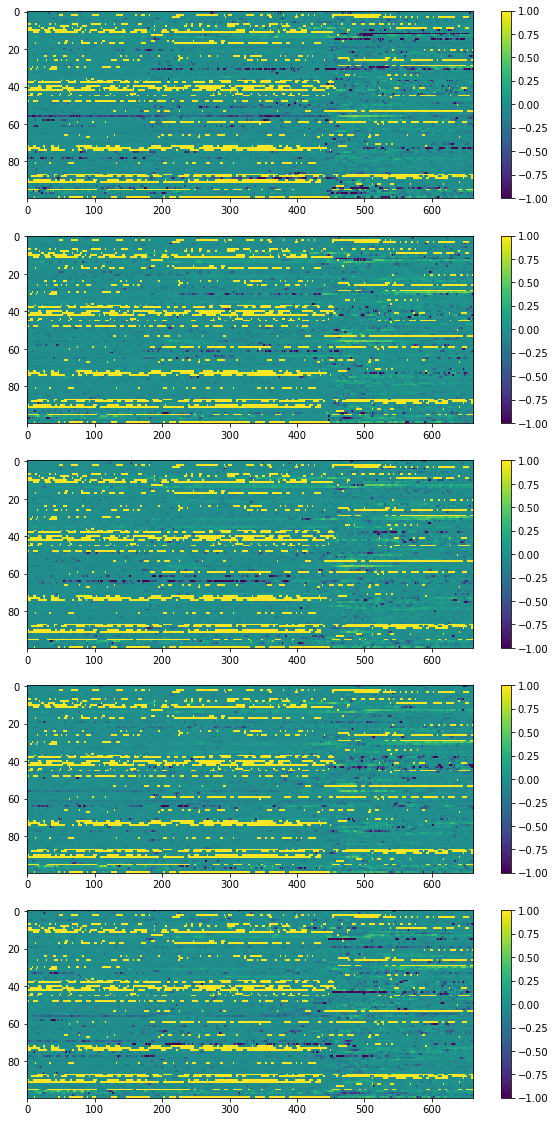

In [87]:
plt.subplots(5,1, figsize=(10,20))

for i in range(5):
    plt.subplot(5,1,i+1)
    plt.imshow(striatum_r2s[:,:,i].T, aspect='auto', cmap = 'viridis', vmin = -1, vmax = 1)
    plt.colorbar()

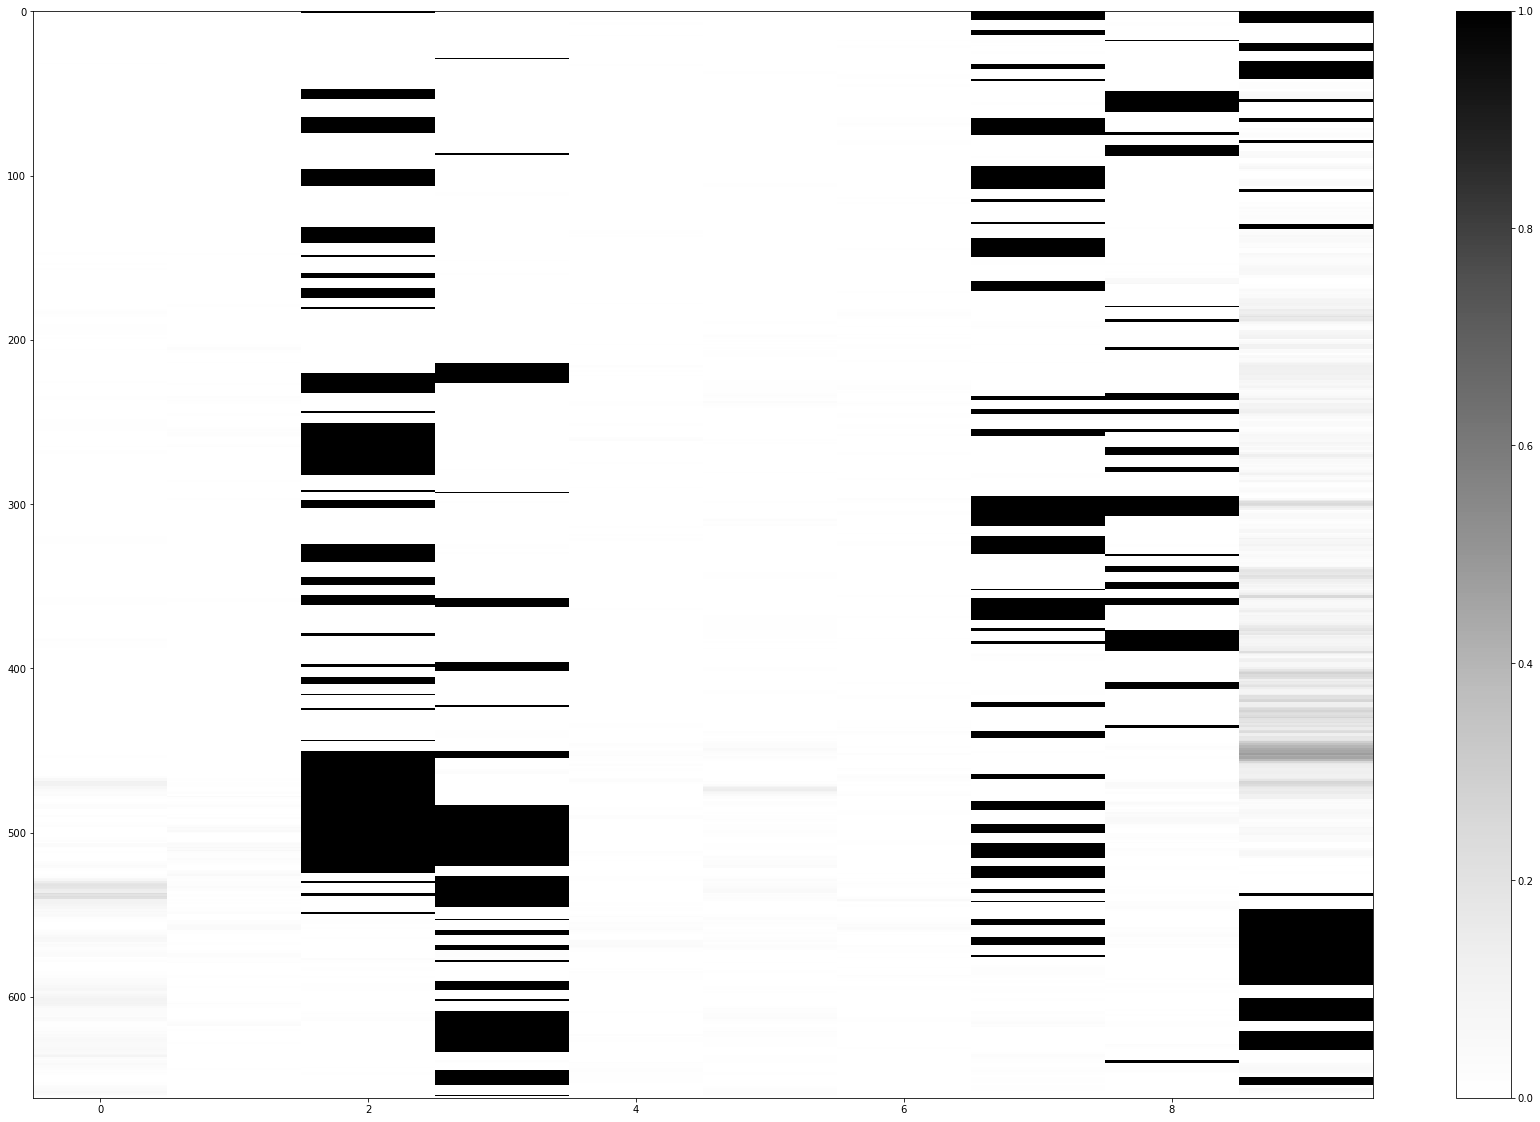

In [103]:
plt.figure(figsize=(30,20))

plt.imshow(relu(striatum_r2s[:,:10,:]).mean(axis=2), aspect='auto', cmap = 'Greys', vmin = 0, vmax = 1)
plt.colorbar()

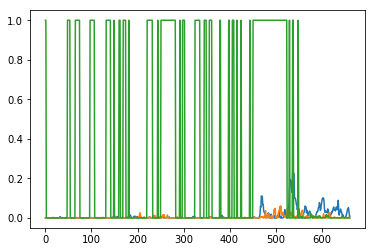

In [105]:
plt.plot(relu(striatum_r2s).mean(axis = 2)[:,:3]);

([array([15.,  0., 14., 14.,  7., 20., 13.,  7.,  1.,  9.]),
  array([ 5., 14., 11.,  9., 17., 10.,  9.,  7.,  7., 11.]),
  array([10.,  3., 18., 18., 14.,  9.,  9.,  4.,  4., 11.]),
  array([ 0.,  7.,  9.,  8.,  3., 15., 31., 16.,  8.,  3.]),
  array([11., 26., 26., 11.,  2.,  0.,  3.,  1., 20.,  0.])],
 array([2.2000e+01, 4.1290e+03, 8.2360e+03, 1.2343e+04, 1.6450e+04,
        2.0557e+04, 2.4664e+04, 2.8771e+04, 3.2878e+04, 3.6985e+04,
        4.1092e+04]),
 <a list of 5 Lists of Patches objects>)

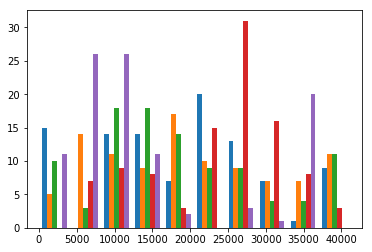

In [65]:
plt.hist(np.array(list(area_large_diff_inds.values())).T)

In [66]:
session_names = r2_newest['5_0']['session_name']
session_names_for_large_diff = {}
for k,v in area_large_diff_inds.items():
    session_names_for_large_diff[k] = list(set(session_names[v]))

{'Medulla': ['SC035_20200109_35', 'SC067_20210414_24', 'SC066_20210421_12', 'SC035_20200107_33', 'SC033_20191113_32', 'SC067_20210415_25', 'SC066_20210420_11', 'SC067_20210419_27', 'SC033_20191115_34', 'SC035_20200108_34', 'SC067_20210418_26', 'SC067_20210420_28', 'SC030_20191005_35', 'SC066_20210414_7', 'SC043_20200924_26', 'SC030_20191004_34', 'SC032_20191218_55', 'SC043_20200922_24', 'SC067_20210413_23', 'SC031_20191021_48', 'SC033_20191114_33', 'SC043_20200923_25', 'SC031_20191023_50', 'SC032_20191220_57', 'SC030_20191003_33'], 'Midbrain': ['SC038_20191119_4', 'SC026_20190808_23', 'SC027_20190729_17', 'SC053_20210222_9', 'SC065_20210504_5', 'SC067_20210414_24', 'SC066_20210421_12', 'SC035_20200107_33', 'SC032_20191219_56', 'SC049_20210107_15', 'SC045_20201214_21', 'SC038_20191120_7', 'SC027_20190730_18', 'SC066_20210420_11', 'SC067_20210419_27', 'SC027_20190731_19', 'SC035_20200108_34', 'SC027_20190801_20', 'SC067_20210418_26', 'SC066_20210415_8', 'SC066_20210416_9', 'SC048_2021010

In [73]:
within_session_inds = {}
for k,v in area_large_diff_inds.items():
    within_session_inds[k] = {}
    for session in session_names_for_large_diff[k]:
        this_sess_inds = np.where(session_names == session)[0]

        within_session_inds[k][session] = np.intersect1d(v, this_sess_inds) - this_sess_inds[0]

In [74]:
within_session_inds['Striatum']

{'SC065_20210511_11': array([58, 79]),
 'SC049_20210111_18': array([  1,  71, 210, 211, 212]),
 'SC053_20210222_9': array([ 98, 116]),
 'SC066_20210421_12': array([163]),
 'SC060_20210323_5': array([306, 311]),
 'SC065_20210507_8': array([21]),
 'SC061_20210323_11': array([249, 281, 302, 314, 487]),
 'SC049_20210110_17': array([ 1, 10, 21, 29, 53]),
 'SC067_20210415_25': array([300]),
 'SC067_20210419_27': array([190, 201]),
 'SC064_20210428_6': array([31, 57, 59, 86]),
 'SC049_20210108_16': array([335, 342, 345]),
 'SC048_20201229_13': array([302, 308]),
 'SC067_20210418_26': array([145, 172]),
 'SC061_20210321_9': array([155, 167, 186, 187, 189, 190, 191, 192]),
 'SC050_20210304_22': array([136]),
 'SC064_20210504_10': array([227]),
 'SC045_20201210_18': array([  1,  21,  87,  95,  96,  99, 105, 106]),
 'SC027_20190804_22': array([241, 392, 411, 418]),
 'SC038_20191123_13': array([272]),
 'SC065_20210514_13': array([127]),
 'SC045_20201211_19': array([169, 174, 178, 201]),
 'SC050_20

In [75]:
with open('large_diff_within_session_inds.pkl', 'wb') as f:
    pickle.dump(within_session_inds, f)

In [68]:
np.where(session_names == 'SC035_20200109_35')[0]

array([18551, 18552, 18553, 18554, 18555, 18556, 18557, 18558, 18559,
       18560, 18561, 18562, 18563, 18564, 18565, 18566, 18567, 18568,
       18569, 18570, 18571, 18572, 18573, 18574, 18575, 18576, 18577,
       18578, 18579, 18580, 18581, 18582, 18583, 18584, 18585, 18586,
       18587, 18588, 18589, 18590, 18591, 18592, 18593, 18594, 18595,
       18596, 18597, 18598, 18599, 18600, 18601, 18602, 18603, 18604,
       18605, 18606, 18607, 18608, 18609, 18610, 18611, 18612, 18613,
       18614, 18615, 18616, 18617, 18618, 18619, 18620, 18621, 18622,
       18623, 18624, 18625, 18626, 18627, 18628, 18629, 18630, 18631,
       18632, 18633, 18634, 18635, 18636, 18637, 18638, 18639, 18640,
       18641, 18642, 18643, 18644, 18645, 18646, 18647, 18648, 18649,
       18650, 18651, 18652, 18653, 18654, 18655, 18656, 18657, 18658,
       18659, 18660, 18661, 18662, 18663, 18664, 18665, 18666, 18667,
       18668, 18669, 18670, 18671, 18672, 18673, 18674, 18675, 18676,
       18677, 18678,

In [15]:
area = 'Medulla'
inds = get_single_area_inds(area, df, ccf_labels)

old_r2 = r2_new['5_0']['response_r2_old'][inds]
new_r2 = r2_new['5_0']['response_r2'][inds]
old_clipped_r2 = old_r2.copy()
old_clipped_r2[old_clipped_r2<0] = 0

In [32]:
np.sort(inds)

array([  963,   964,   965, ..., 41094, 41095, 41096])

array([1525,    2,  480, 1514, 1584, 1909, 2079,   70,  737,  605,  783,
       1606,  946,  904,    3, 1829, 1887, 2044, 1256, 1522, 1521, 1524,
       1800, 1118,  751, 1501, 1926,  940,  525,  433, 1692,  746, 1276,
       1507, 1916, 1236,   86, 2199, 2040,  869,  841, 1178, 1023,  372,
       2171,  735, 1159,  389, 2043, 1211, 2045,  839,  818,  523,  813,
        181, 1082,  807,  219, 1264, 1370,    0, 2049, 2203,  827, 2011,
       2261,  878, 1297,  383,  443,  607, 1972,  874, 2162,  200, 1925,
       1313, 1583,  831,  757, 1516, 2201,  717, 1320, 1203, 1683, 2130,
       1899, 1078, 1312, 1710,   78,  745,  353, 1081, 1123, 1608, 1802,
         62])

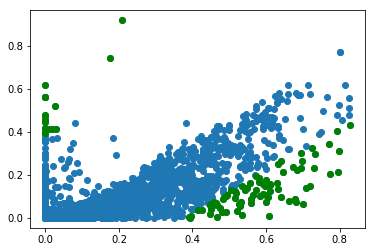

In [30]:
plt.plot(old_clipped_r2, new_r2, 'o')

large_diff_inds = np.argsort(np.abs(old_clipped_r2 - new_r2))[::-1][:100]

plt.plot(old_clipped_r2[large_diff_inds], new_r2[large_diff_inds], 'go')

large_diff_inds

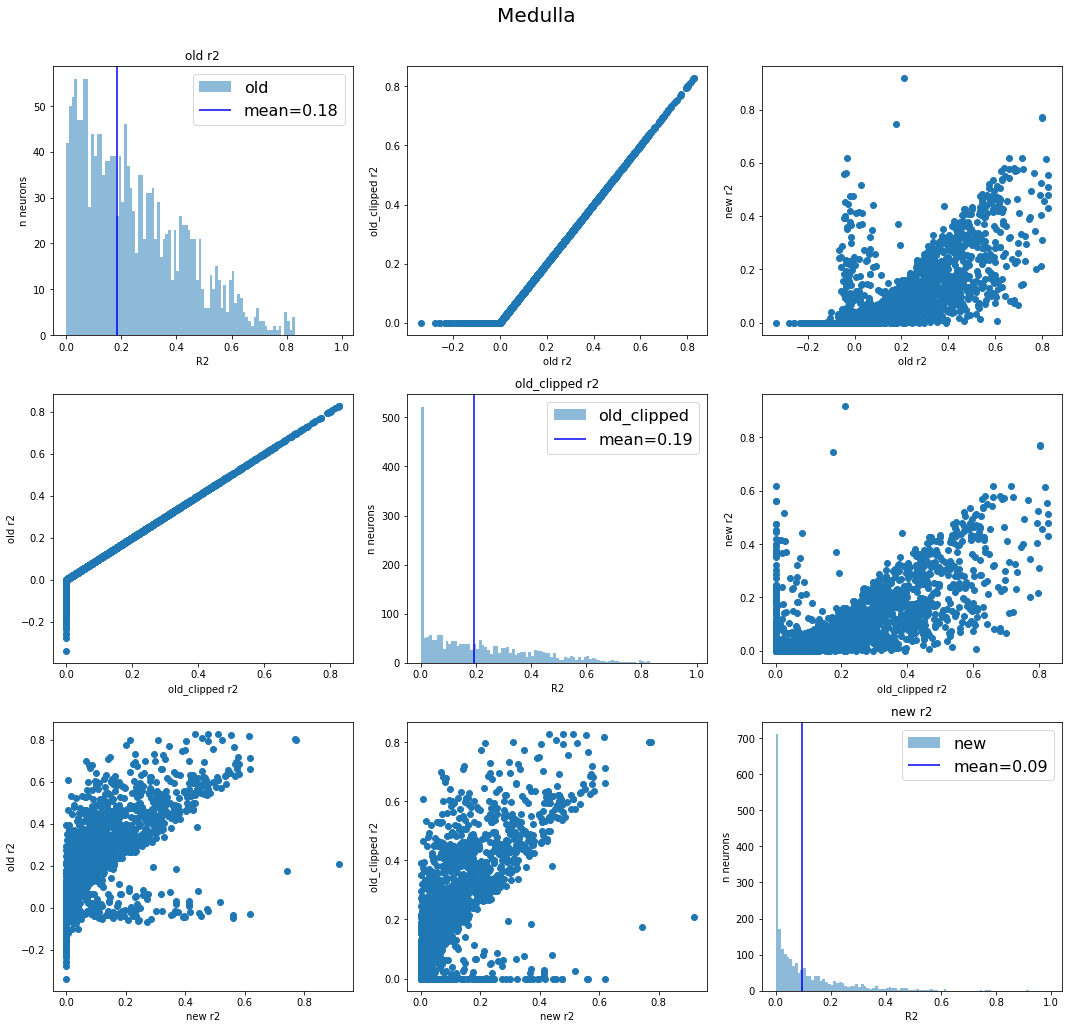

In [33]:
data = [old_r2, old_clipped_r2, new_r2]
labels = ['old', 'old_clipped', 'new']

plt.subplots(3,3, figsize = (15,15))
plt.suptitle(area, fontsize=20)  # Add an overall title here

for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)

        if i != j:
            plt.plot(data[i], data[j], 'o')
            plt.xlabel('%s r2'%labels[i])
            plt.ylabel('%s r2'%labels[j])

        elif i==j:
            plt.hist(data[i], bins = np.arange(0,1.,0.01), alpha = 0.5, label = labels[i])
            mean = data[i].mean()
            a,b = plt.ylim()
            plt.vlines(mean, a, b, color = 'blue', label = 'mean=%.2f'%mean)
            plt.ylim(a,b)
            plt.xlabel('R2')
            plt.ylabel('n neurons')
            plt.title('%s r2'%labels[i])
            plt.legend(fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the suptitle



In [36]:
r2_newest = pickle.load(open('r2_data_dict_timeshifts.pkl', 'rb'))
ccf_labels_v2 = r2_newest['5_0']['ccf_labels'].copy()
is_alm = r2_newest['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]

In [37]:
alm_inds

array([  574,   575,   576, ..., 41235, 41236, 41237])

In [38]:
areas = ['Medulla','Midbrain', 'ALM', 'Striatum', 'Thalamus',]
for j,area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds
    else:
        inds = get_single_area_inds(area, df, ccf_labels_v2)


    old_r2 = r2_newest['5_0']['response_r2_old'][inds]
    new_r2 = r2_newest['5_0']['response_r2'][inds]
    old_clipped_r2 = old_r2.copy()
    old_clipped_r2[old_clipped_r2<0] = 0

    data = [old_r2, old_clipped_r2, new_r2]
    labels = ['old', 'old_clipped', 'new']

    plt.subplots(3,3, figsize = (15,15))
    plt.suptitle(area, fontsize=20)  # Add an overall title here

    for i in range(3):
        for j in range(3):
            plt.subplot(3,3,3*i+j+1)

            if i != j:
                plt.plot(data[i], data[j], 'o')
                plt.xlabel('%s r2'%labels[i])
                plt.ylabel('%s r2'%labels[j])

            elif i==j:
                plt.hist(data[i], bins = np.arange(0,1.,0.01), alpha = 0.5, label = labels[i])
                mean = data[i].mean()
                a,b = plt.ylim()
                plt.vlines(mean, a, b, color = 'blue', label = 'mean=%.2f'%mean)
                plt.ylim(a,b)
                plt.xlabel('R2')
                plt.ylabel('n neurons')
                plt.title('%s r2'%labels[i])
                plt.legend(fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the suptitle
    plt.savefig('figs/epochs/r2_draftsman_response_%s.png'%area)
    plt.close()


In [61]:
np.all(r2_newest['5_0']['is_alm'] == r2_newest['5_12']['is_alm'])

True

In [20]:
area = 'Medulla'
inds = get_single_area_inds(area, df, ccf_labels_v2)

old_r2_v2 = r2_newest['5_0']['response_r2_old'][inds]
new_r2_v2 = r2_newest['5_0']['response_r2'][inds]
old_clipped_r2_v2 = old_r2_v2.copy()
old_clipped_r2_v2[old_clipped_r2_v2<0] = 0


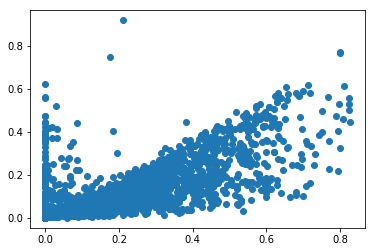

In [21]:
plt.plot(old_clipped_r2_v2, new_r2_v2, 'o')

In [10]:
response_r2 = r2_new['5_0']['response_r2_old']
ccf_labels = r2_new['5_0']['ccf_labels']
response_fr = r2_new['5_0']['response_fr']
session_labels = r2_new['5_0']['session_name']
animals = list(set([sess[:5] for sess in session_labels]))
inds_for_animals = {}
for animal in np.sort(animals):
    inds_for_animals[animal] = np.where([sess[:5] == animal for sess in session_labels])[0]



#### Scatter plots for areas


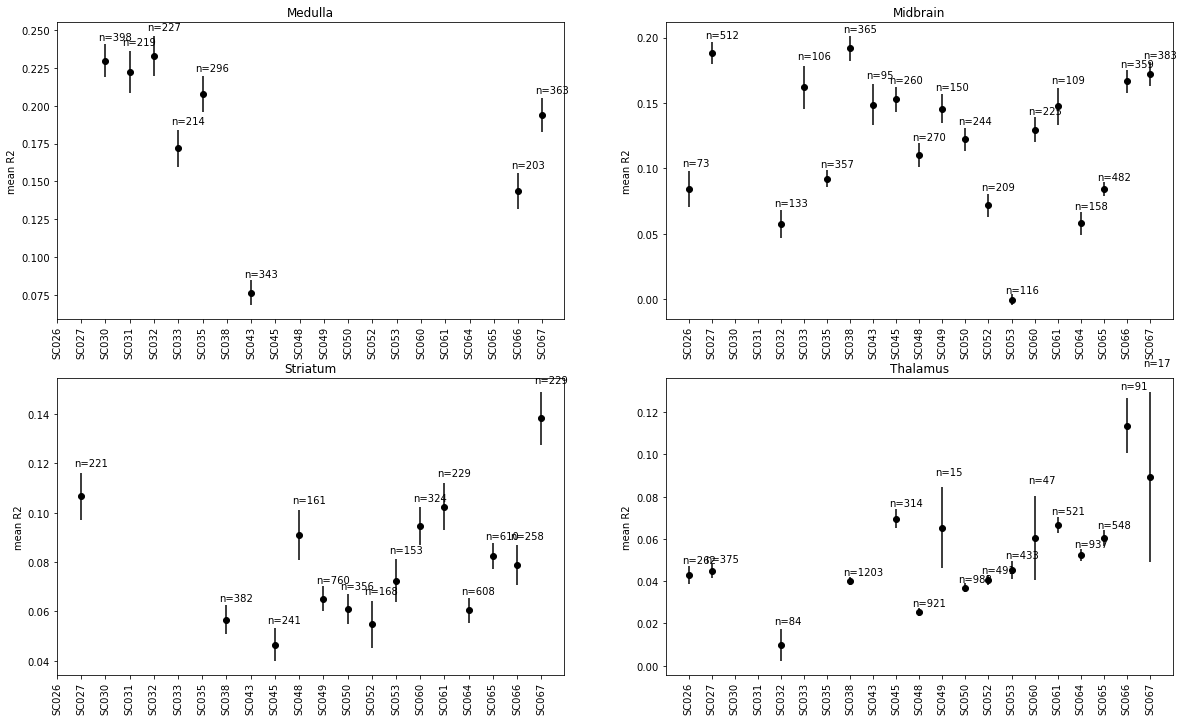

In [23]:
areas = ['Medulla','Midbrain', 'Striatum', 'Thalamus',]

plt.subplots(2,2,figsize=(20,12))

for i, area in enumerate(areas):
    inds = get_single_area_inds(area, df, ccf_labels)

    plt.subplot(2,2,i+1)

    j= 0

    for k in inds_for_animals.keys():
        v = inds_for_animals[k]
        this_animal_inds = np.intersect1d(v,inds)
        if len(this_animal_inds) == 0:
            j+=1
            continue
        mean = response_r2[this_animal_inds].mean()
        std = response_r2[this_animal_inds].std()
        sem = std/np.sqrt(this_animal_inds.shape[0])
        plt.errorbar([j],mean,yerr=sem,color = 'k', fmt = 'o')
        plt.text(j-0.3,mean + sem + 0.3 * sem, 'n=%d'%this_animal_inds.shape[0], fontsize=10, color='black')
        j+=1

    plt.title(area)
    plt.ylabel('mean R2')
    plt.xticks(np.arange(0,len(animals)), list(inds_for_animals.keys()), rotation = 90);

plt.savefig('figs/single_animal_r2_by_area.png')
    

#### Single animal plots for all regions

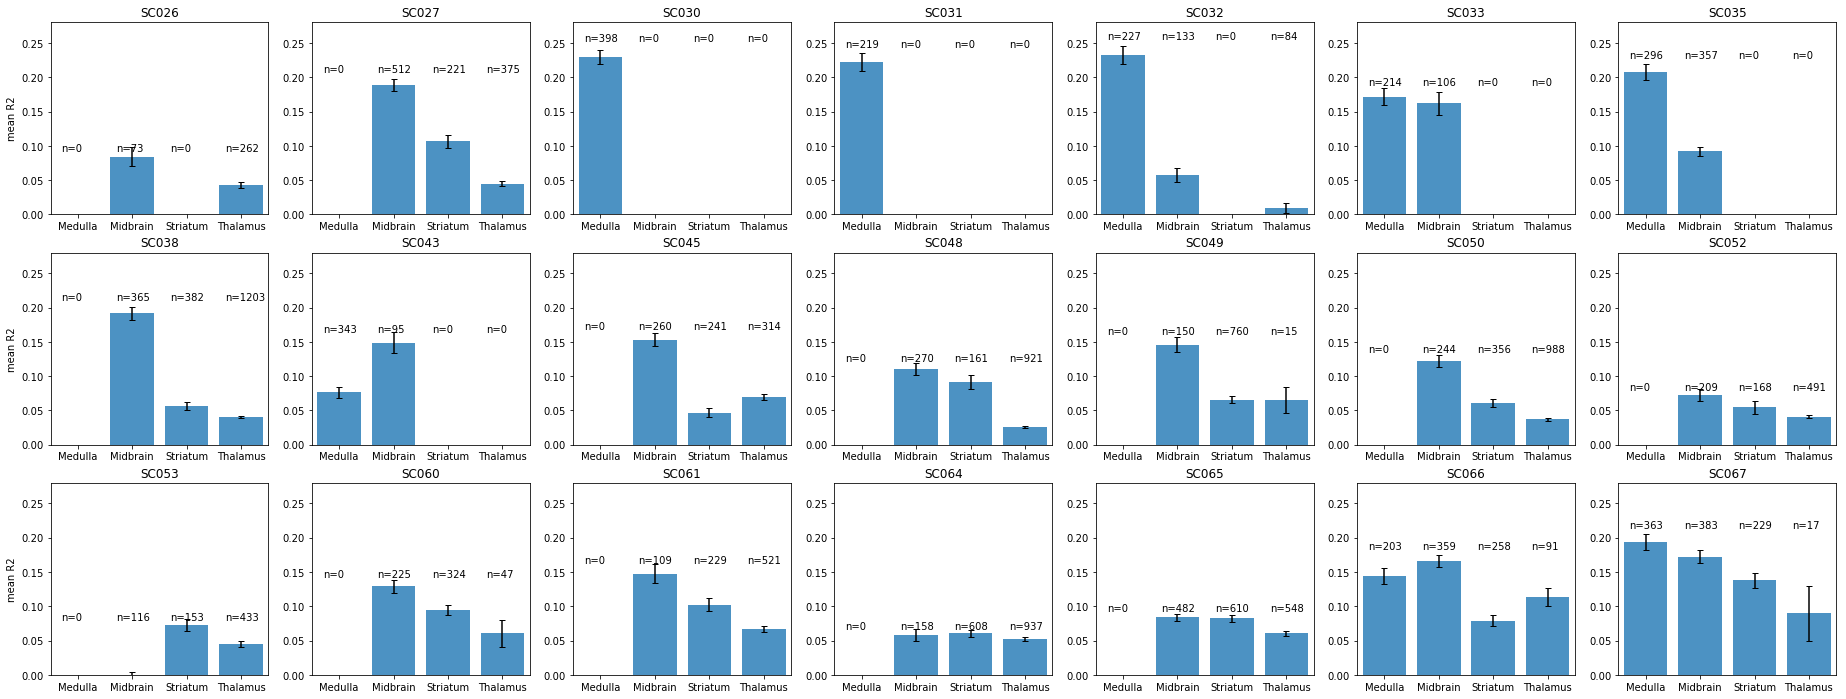

In [24]:
plt.subplots(3,7, figsize = (32,12))

for i, animal in enumerate(inds_for_animals.keys()):
    plt.subplot(3,7,i+1)
    plt.title(animal)

    area_values = []
    area_sems = []
    n_neurons = []
    for j, area in enumerate(areas):
        inds = get_single_area_inds(area, df, ccf_labels)
        this_animal_inds = np.intersect1d(inds_for_animals[animal],inds)
        n_neurons.append(len(this_animal_inds))
        if len(this_animal_inds) == 0:
            area_values.append(np.nan)
            area_sems.append(np.nan)
            continue
        mean = response_r2[this_animal_inds].mean()
        std = response_r2[this_animal_inds].std()
        sem = std/np.sqrt(this_animal_inds.shape[0])
        area_values.append(mean)
        area_sems.append(sem)

    plt.bar(np.arange(0,len(areas)), area_values, yerr = area_sems, alpha = 0.8, capsize = 3)
    plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
    if i%7 == 0: plt.ylabel('mean R2')
    for j in range(len(areas)):
        plt.text(j-0.3,1.1*np.nanmax(area_values), 'n=%d'%n_neurons[j], fontsize=10, color='black')

    plt.xlim(-0.5,3.5)
    plt.ylim(0,0.28)

plt.savefig('figs/mean_r2_by_area.png')

Check overall area averages.

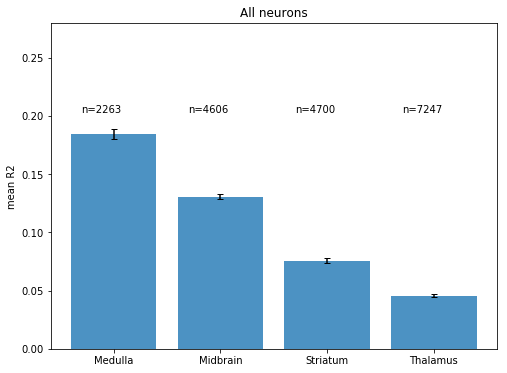

In [25]:
area_values = []
area_sems = []
n_neurons = []
for j, area in enumerate(areas):
    inds = get_single_area_inds(area, df, ccf_labels)
    n_neurons.append(len(inds))
    mean = response_r2[inds].mean()
    std = response_r2[inds].std()
    sem = std/np.sqrt(inds.shape[0])
    area_values.append(mean)
    area_sems.append(sem)

plt.figure(figsize=(8,6))
plt.bar(np.arange(0,len(areas)), area_values, yerr = area_sems, alpha = 0.8, capsize = 3)
plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
plt.ylabel('mean R2')
plt.title('All neurons')
for j in range(len(areas)):
    plt.text(j-0.3,1.1*np.nanmax(area_values), 'n=%d'%n_neurons[j], fontsize=10, color='black')

plt.ylim(0,0.28)
plt.savefig('figs/mean_r2_by_area_all_animals.png')

#### Leave one out plots for all regions

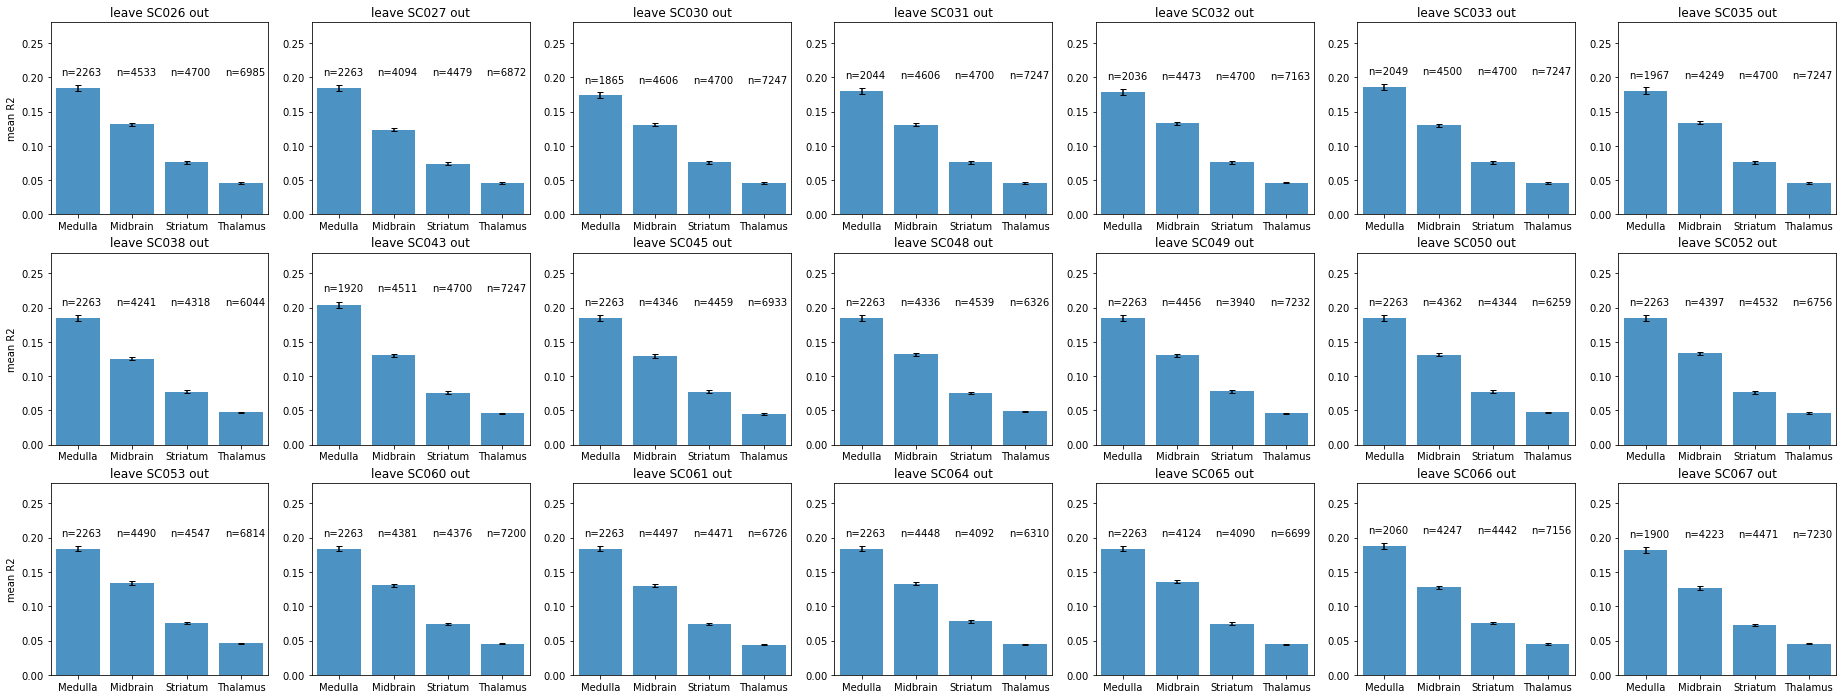

In [27]:
plt.subplots(3,7, figsize = (32,12))

area_avgs = []
area_errs = []
area_ns = []

for i, animal in enumerate(inds_for_animals.keys()):
    plt.subplot(3,7,i+1)
    plt.title('leave %s out'%animal)

    area_values = []
    area_sems = []
    n_neurons = []
    for j, area in enumerate(areas):
        inds = get_single_area_inds(area, df, ccf_labels)
        not_this_animal_inds = np.setdiff1d(inds,inds_for_animals[animal])
        n_neurons.append(len(not_this_animal_inds))
        if len(not_this_animal_inds) == 0:
            area_values.append(np.nan)
            area_sems.append(np.nan)
            continue
        mean = response_r2[not_this_animal_inds].mean()
        std = response_r2[not_this_animal_inds].std()
        sem = std/np.sqrt(not_this_animal_inds.shape[0])
        area_values.append(mean)
        area_sems.append(sem)

    area_avgs.append(np.array(area_values))
    area_errs.append(np.array(area_sems))
    area_ns.append(np.array(n_neurons))
    plt.bar(np.arange(0,len(areas)), area_values, yerr = area_sems, alpha = 0.8, capsize = 3)
    plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
    if i%7 == 0: plt.ylabel('mean R2')
    for j in range(len(areas)):
        plt.text(j-0.3,1.1*np.nanmax(area_values), 'n=%d'%n_neurons[j], fontsize=10, color='black')

    plt.xlim(-0.5,3.5)
    plt.ylim(0,0.28)

plt.savefig('figs/mean_r2_by_area_forall_leaveoneout.png')

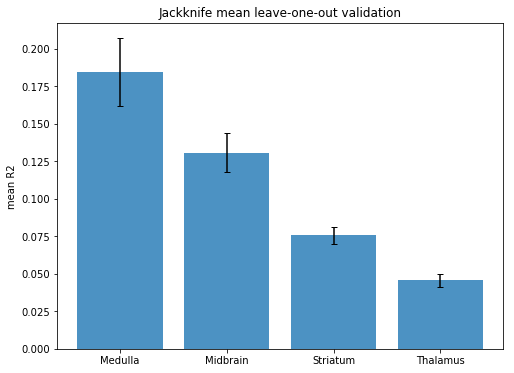

In [29]:
area_avgs = np.array(area_avgs)

jackknife_means = np.mean(area_avgs, axis = 0)
N = area_avgs.shape[0]
jackknife_vars = ((N - 1) / N) * np.sum((area_avgs - jackknife_means[np.newaxis,:])**2, axis = 0)
jackknife_se = np.sqrt(jackknife_vars)

plt.figure(figsize=(8,6))
plt.bar(np.arange(0,len(areas)), jackknife_means, yerr = jackknife_se, alpha = 0.8, capsize = 3)
plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
plt.ylabel('mean R2')
plt.title('Jackknife mean leave-one-out validation')

plt.savefig('figs/jackknife_mean_r2_by_area.png')